# Price Prediction Models


In [ ]:
import torch, torchvision, PIL, numpy as np
import torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from tqdm.auto import tqdm
import math
import random
from collections import OrderedDict
#torch.manual_seed(0)
#np.random.seed(0)
#torch.set_deterministic(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data_nd/"

In [ ]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')
        
        self.artists_list = np.loadtxt(root_dir / 'artists_list.gz', str, delimiter=",")

        def get_input(fn):
            imgfn = fn
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['imageName'] == fn]
            try:
              index = row.index[0]
            except:
              print(fn)
              print(row)
              input()
            price_log = math.log(row['price'][index]) # log because we are scientists
            dimensions = math.log(float(row['width'][index]) * float(row['height'][index]))
            #artist_encoded = np.zeros(5197)
            try:
              artist_index = np.where(self.artists_list == str(row['artist'][index]))[0][0]
            except:
              print(str(row['artist'][index]))
              print(np.where(self.artists_list == str(row['artist'][index])))
              input()
            #artist_encoded[artist_index] = 1
            return imgfn, dimensions, artist_index, price_log

        self.fns_labels = [(get_input(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, di, ae, label = self.fns_labels[i]
        #ae = np.append(ae, di)
        #ae = torch.from_numpy(ae).float()
        img = PIL.Image.open(imgfn)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, ae, di, label)

In [ ]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img, _, _, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [ ]:
dataset_tmp = PricePredictionDataset(dataset_dir)

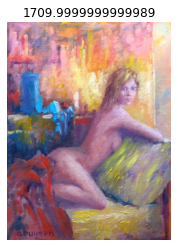

In [ ]:
show_img_price(dataset_tmp[78])

In [ ]:
# Transform for benchmarking model # NOT USED ANYMORE
def randolabo(anything):
  return random.random() * 3 + 6 # log(20000) ~ 9.9, log(1000) ~ 6.9

19398


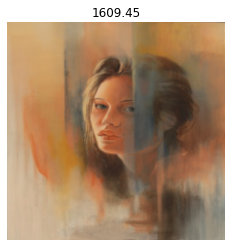

In [ ]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
#dataset_full= PricePredictionDataset(dataset_dir, True, transform=xform)
dataset_full= PricePredictionDataset(dataset_dir, False, transform=xform)
print(len(dataset_full))
show_img_price(dataset_full[102])

In [ ]:
n_all= len(dataset_full)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train), len(dataset_test)

(15518, 3880)

In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
pt = True
trim = False
model= torchvision.models.resnet34(pretrained=pt) # complicated models tend to overfit
print(model.fc.in_features) # fc for resnet
#print(model.classifier.in_features) # classifier for densenet
#print(model.classifier[-1].in_features) # classifier[-1] for vgg

#for param in model.parameters():
#  param.requires_grad = False # freeze pretrained layers, otherwise it tends to overfit quickly

# from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
if (trim):
  model.layer3 = Identity();
  model.layer4 = Identity();

# from https://discuss.pytorch.org/t/reset-model-weights/19180/4
def weights_init(m):
  if isinstance(m, torch.nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight.data)

if (not pt):
  model.apply(weights_init)
  for child in model.children():
    child.apply(weights_init)
    for c in child.children():
      c.apply(weights_init)
      for h in c.children():
        h.apply(weights_init)
        for i in h.children():
          i.apply(weights_init)


model.fc = torch.nn.Sequential(
  Identity()
)
#torch.nn.init.xavier_uniform_(model.fc[0].weight)

device = torch.device('cuda:0')
model.to(device);


512


In [ ]:
class Net(nn.Module):
    def __init__(self, transferred):
        super(Net, self).__init__()
        self.tr = transferred
        self.emb = nn.Embedding(5198, 64) # 5197 + 1 for other
        self.fc = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(in_features=512 + 64 + 1, out_features=2048), # resnet_out + artists + dimensions
            'relu1': torch.nn.ReLU(),
            'lin3': nn.Linear(in_features=2048, out_features=512),
            'relu3': torch.nn.ReLU(),
            'lin4': nn.Linear(in_features=512, out_features=1)
        }))
        torch.nn.init.xavier_uniform_(self.fc[0].weight)
        torch.nn.init.xavier_uniform_(self.fc[2].weight)
        torch.nn.init.xavier_uniform_(self.fc[4].weight)

    def forward(self, img, art, di):
        x = self.tr(img)
        emb = self.emb(art)
        x = torch.cat((x,emb,di), 1)
        x = self.fc(x)
        return x


In [ ]:
def run_test(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, art_ind, dim, labels in loader_test:
            samples = samples.to(device)
            art_ind = art_ind.to(device)
            dim = dim.to(device).unsqueeze(1).float()
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples, art_ind, dim)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()
    with torch.enable_grad():
        for samples, art_ind, dim, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            art_ind = art_ind.to(device)
            dim = dim.to(device).unsqueeze(1).float()
            labels = labels.to(device).float().unsqueeze(1)
            opt.zero_grad()
            outs = model(samples, art_ind, dim)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            if (math.isnan(loss.item())):
              print("loss nan")
              print(loss)
    sched.step()
    return loss_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test



In [ ]:
net = Net(model)
net = net.to(device)

In [ ]:
criterion = torch.nn.MSELoss()
# For pretrained
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 10, 20, 30], gamma=0.1)


In [ ]:
run_all(net, criterion, optimizer, scheduler, 10)

epoch 1: train loss 1.0274, test loss 0.5109


epoch 2: train loss 0.5754, test loss 0.5241


epoch 3: train loss 0.5584, test loss 0.4942


epoch 4: train loss 0.5579, test loss 0.4943


epoch 5: train loss 0.5553, test loss 0.4918


epoch 6: train loss 0.5552, test loss 0.4918


epoch 7: train loss 0.5543, test loss 0.4920


epoch 8: train loss 0.5547, test loss 0.4921


epoch 9: train loss 0.5546, test loss 0.4921


epoch 10: train loss 0.5547, test loss 0.4921



tensor(0.4921, device='cuda:0')

In [ ]:
model

id | model | layers | criterion | optimizer | scheduler | epochs | train loss | test loss | notes
--- | --- | --- | --- | --- |--- | --- | --- | --- | ---
| resnet18 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 5 | 0.7941 | 0.7835 | w/o artists or dimensions
| resnet34 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 10 | 0.7889 | 0.7821 | w/o artists or dimensions
| resnet50 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 10 | 0.7890 | 0.7821 | w/o artists or dimensions
| resnet152 | fc=1 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=3, gamma=0.1 | 8 | 0.7890 | 0.7821 | w/o artists or dimensions
1 | resnet34 | Net 4 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 10 | 0.5315|  0.4719| 
2 | resnet50 | Net 4 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 10 | 0.5314|  0.4718| 
3 | resnet34 | Net 3 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 6 | 0.5546|  0.4921| used embedding size=256
4 | resnet34 | Net 3 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 6 | 0.5551 |  0.4918| used embedding size=125
5 | resnet34 | Net 3 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 6 | 0.5547|  0.4920| used embedding size=512
6 | resnet34 | Net 3 linear | MSELoss | SGD, lr=0.01, m=0.1 | StepLR ss=2, gamma=0.1 | 6 | 0.5547|  0.4921| used embedding size=64

In [ ]:
torch.save(net.state_dict(), '/content/drive/My Drive/CPEN 291/project/sd/model_1.pth')


In [ ]:
torch.save(net, '/content/drive/My Drive/CPEN 291/project/models/model_5_5.pkl')

In [ ]:
test_loss, test_preds= run_test(net, criterion)
print(test_loss)

tensor(0.4921, device='cuda:0')


In [ ]:
test_preds[0]

tensor([6.9605])

Prediction     | Real Price


ValueError: ignored

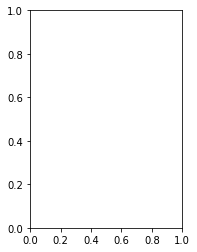

In [ ]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price((dataset_test[i][0], None, None, test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price(dataset_test[i])
    plt.show(block=True)
